# Categorical Data Training

The data used for this training is the categorical masks of floors
The Height mask is divided into binary masks based on 4 categories
1. 0 ->  Ground
2. 1-4 -> Short Building
3. 5-10 -> Medium Building
4. 11+ -> Tall Building


### Download Data

In [1]:
!pip -q install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00


In [2]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Datasets/42Chinesecities_SM/data_cat.zip' -d '.'
!mv 'data_cat' 'data'

## Imports

In [4]:
import os
import yaml
import random

from models.clipseg import CLIPDensePredT

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Config Variables

In [5]:
# Data
ROOT_DIR = './data'
BATCH_SIZE = 32
TRANSFORMS = None
SHUFFLE = True
SEED = 42
NUM_WORKERS = 0
PIN_MEMORY = True
# Training
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3
EPOCHS = 2


## Dataloaders and visualization

In [6]:
class ChineseCityDataset(Dataset):
    def __init__(self, root_dir='./data' ,split='train', transform=None):
        super().__init__()

        if split == 'train':
            self.base_dir = f'{root_dir}/train'
        elif split == 'test':
            self.base_dir = f'{root_dir}/test'
        elif split == 'val':
            self.base_dir = f'{root_dir}/val'
        else:
            raise Exception(f"Invalid split parameter! '{split}' not in ['train', 'test', 'val']")

        # variables
        self.image_dir = f'{self.base_dir}/images'
        self.masks_dir = f'{self.base_dir}/masks'

        self.images = os.listdir(self.image_dir)
        self.mask_dirs = os.listdir(self.masks_dir)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]

        img = read_image(f'{self.base_dir}/images/{image_name}', mode=ImageReadMode.RGB) / 255

        # Remove the view id from the image name: Image Name = {image_id}_{view}
        masks_dir_id = image_name.split('_')[0]

        # Masks info
        ## 0 = Ground Floor: 0
        ## 1-4 =  Short Building or a house: 1
        ## 5-10 = Meduim Building: 2
        ## 11+ = Tall Building: 3

        masks = []
        for mask_number in range(4):
            mask = read_image(f'{self.masks_dir}/{masks_dir_id}/{mask_number}.png', mode=ImageReadMode.GRAY) / 255
            masks.append(mask)


        if self.transform:
            img = self.transform(img)
            masks = [self.transform(mask) for mask in masks]

        return img, masks

In [7]:
train_data = ChineseCityDataset(root_dir=ROOT_DIR, split='val')
trainloader = DataLoader(train_data,
                         batch_size=BATCH_SIZE,
                         shuffle=SHUFFLE,
                         generator=torch.Generator().manual_seed(SEED),
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY
                         )

In [8]:
images, [mask0, mask1, mask2, mask3] = next(iter(trainloader))

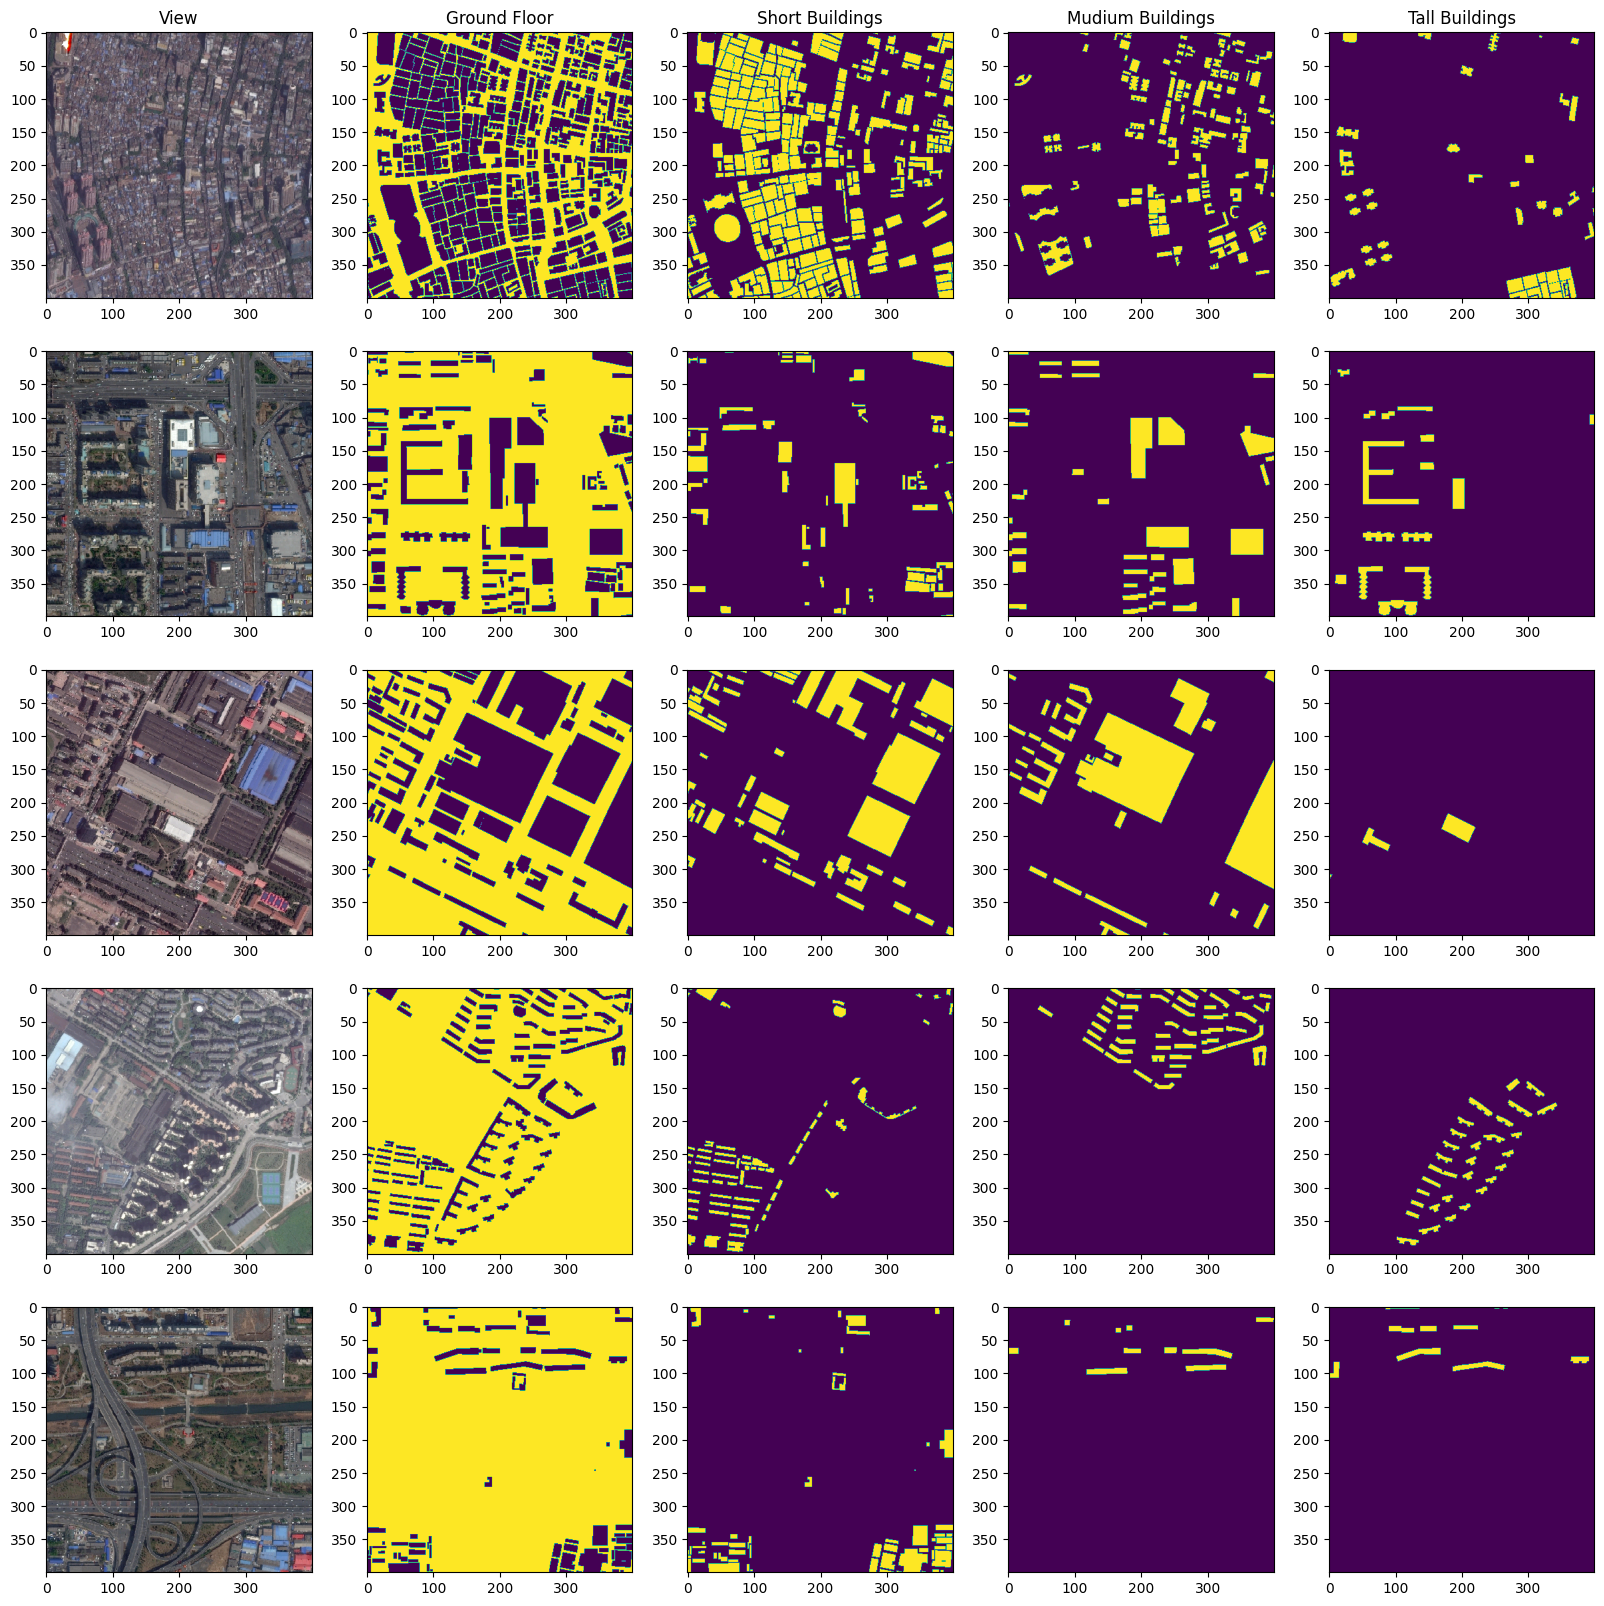

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

axes[0,0].set_title("View")
axes[0,1].set_title("Ground Floor")
axes[0,2].set_title("Short Buildings")
axes[0,3].set_title("Mudium Buildings")
axes[0,4].set_title("Tall Buildings")

for idx in range(5):
    axes[idx, 0].imshow(images[idx].permute(1,2,0))
    axes[idx, 1].imshow(mask0[idx].permute(1,2,0))
    axes[idx, 2].imshow(mask1[idx].permute(1,2,0))
    axes[idx, 3].imshow(mask2[idx].permute(1,2,0))
    axes[idx, 4].imshow(mask3[idx].permute(1,2,0))

plt.show()

## Training setup

In [21]:
model = CLIPDensePredT(version='ViT-B/16', complex_trans_conv=True).to(DEVICE)

In [22]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters are: {trainable_params:,}")

Total number of trainable parameters are: 561,489


In [23]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [24]:
with open(f'config/prompts.yaml', 'r') as f:
    _prompts = yaml.safe_load(f)


def get_random_prompts(mask_type, n_prompts, prompts=_prompts):
    valid_mask_types = [0,1,2,3]
    assert mask_type in valid_mask_types, f"Invalid mask_type! {mask_type} not in {valid_mask_types}"

    key_list = ["PromptsMask0", "PromptsMask1", "PromptsMask2", "PromptsMask3"]

    random_prompts = []
    for i in range(n_prompts):
        random_prompt = random.choice(prompts[key_list[mask_type]])
        random_prompts.append(random_prompt)

    return random_prompts


## Training Loop

In [26]:
loss_list = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for idx, (images, masks) in tqdm(enumerate(trainloader), total=len(trainloader), desc=f'Epoch {epoch+1}/{EPOCHS}: '):
        images = images.to(DEVICE)
        masks = [mask.to(DEVICE) for mask in masks]

        # Loop through the masks and feed them to the model with image and random prompt.
        batch_loss = 0.0
        for mask_idx, mask in enumerate(masks):
            print(mask.shape)
            optimizer.zero_grad()
            prompts = get_random_prompts(mask_type=mask_idx, n_prompts=mask.shape[0])

            pred_mask = model(images, prompts)[0]
            loss = criterion(pred_mask, mask)

            loss.backward()
            optimizer.step()

            batch_loss += loss.item()

        epoch_loss += batch_loss
    print(f"Loss: {epoch_loss:.4f}.")

    loss_list.append(epoch_loss)


Epoch 1/2:   0%|          | 0/28 [00:00<?, ?it/s]

Loss: 14.385646661743522.


Epoch 2/2:   0%|          | 0/28 [00:00<?, ?it/s]

Loss: 10.983958365395665.


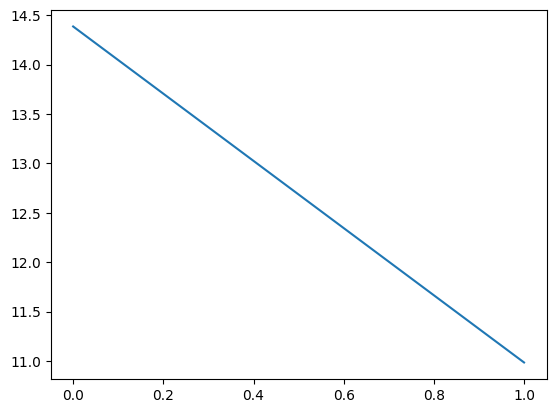

In [27]:
plt.plot(loss_list)

In [44]:
test_data = ChineseCityDataset(root_dir=ROOT_DIR, split='test')
testloader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=SHUFFLE,
                         generator=torch.Generator().manual_seed(SEED),
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY
                         )

In [47]:
images, [mask0, mask1, mask2, mask3] = next(iter(testloader))
with torch.no_grad():
    prompts = get_random_prompts(0, images.shape[0])
    outs = model(images, prompts)[0]
    outs = outs.detach().cpu()

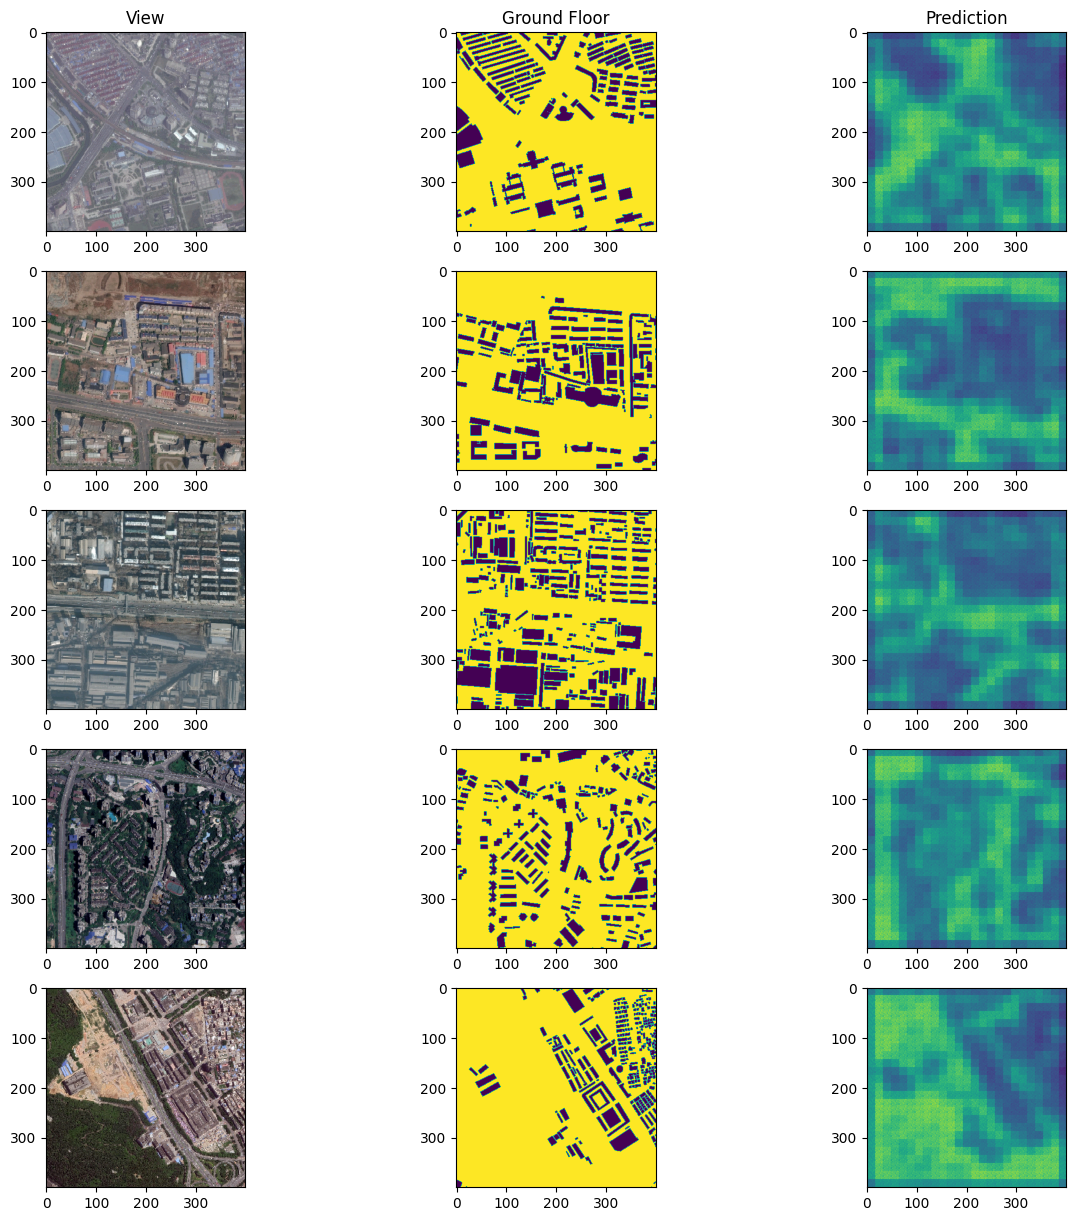

In [48]:
fig, axes = plt.subplots(5, 3, figsize=(15, 15))

axes[0,0].set_title("View")
axes[0,1].set_title("Ground Floor")
axes[0,2].set_title("Prediction")

for idx in range(5):
    axes[idx, 0].imshow(images[idx].permute(1,2,0))
    axes[idx, 1].imshow(mask0[idx].permute(1,2,0))
    axes[idx, 2].imshow(outs[idx].permute(1,2,0))

plt.show()